# Movie Reccommendation With MovieLens

## Step 1: Investigate Data

Ratings Data


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931



Movies Data


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy



Tags Data


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200



Links Data


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0



Ratings Summary Statistics


,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09



Number of unique users: 610
Number of unique movies: 9724


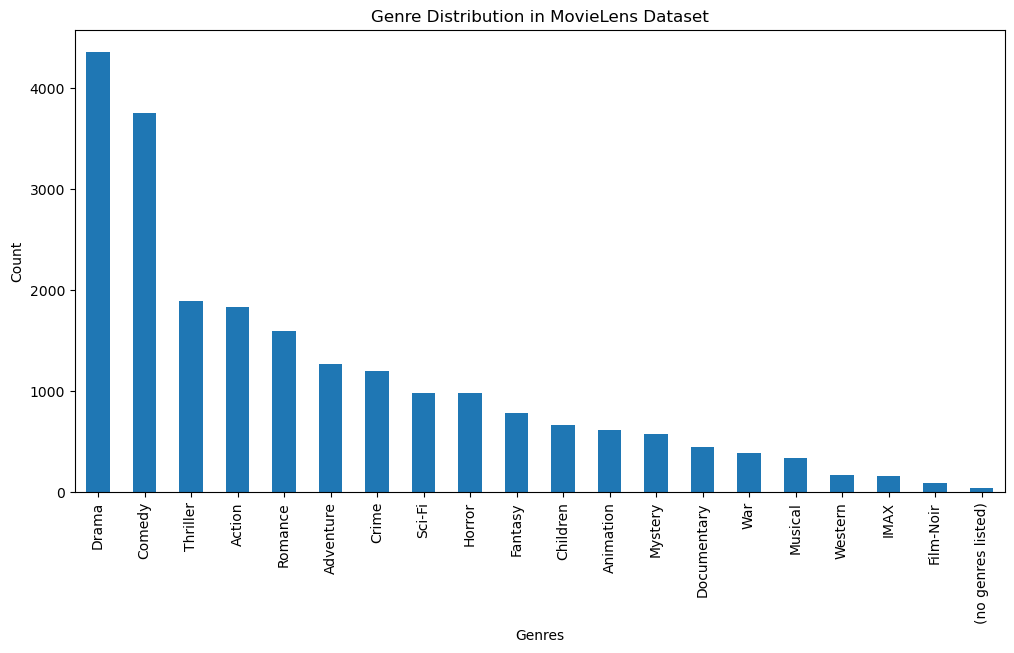

Original number of ratings: 100836
Number of ratings after filtering: 100836
Number of users after filtering: 610
Original number of tags: 3683
Number of tags after filtering: 3683
Number of users in tags data after filtering: 58


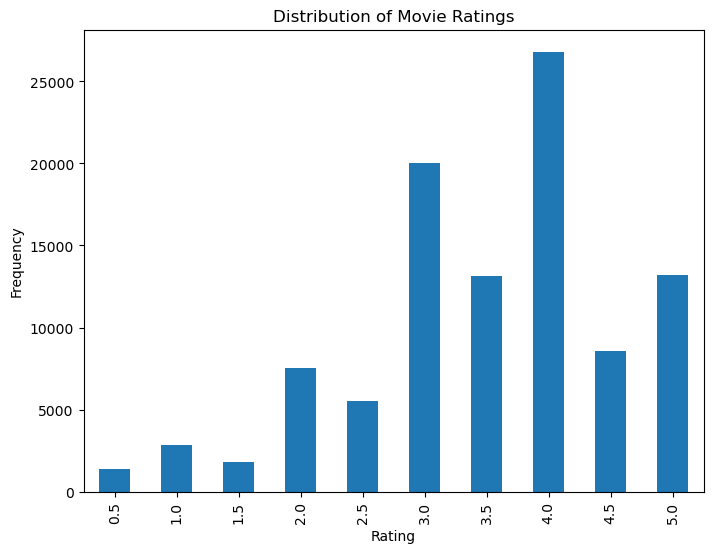

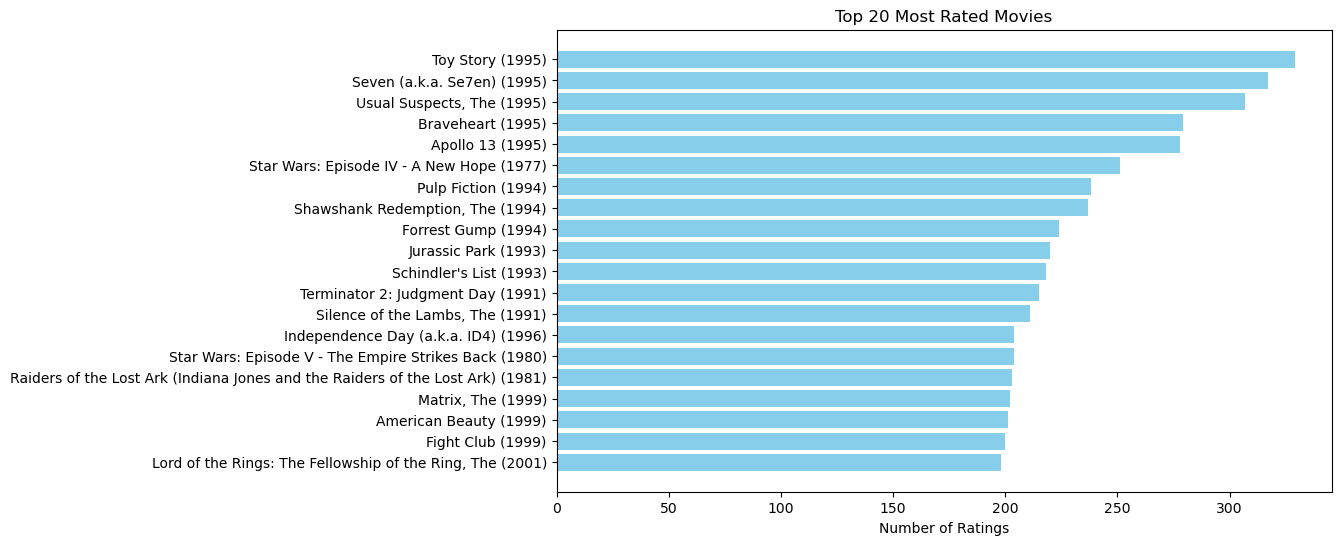

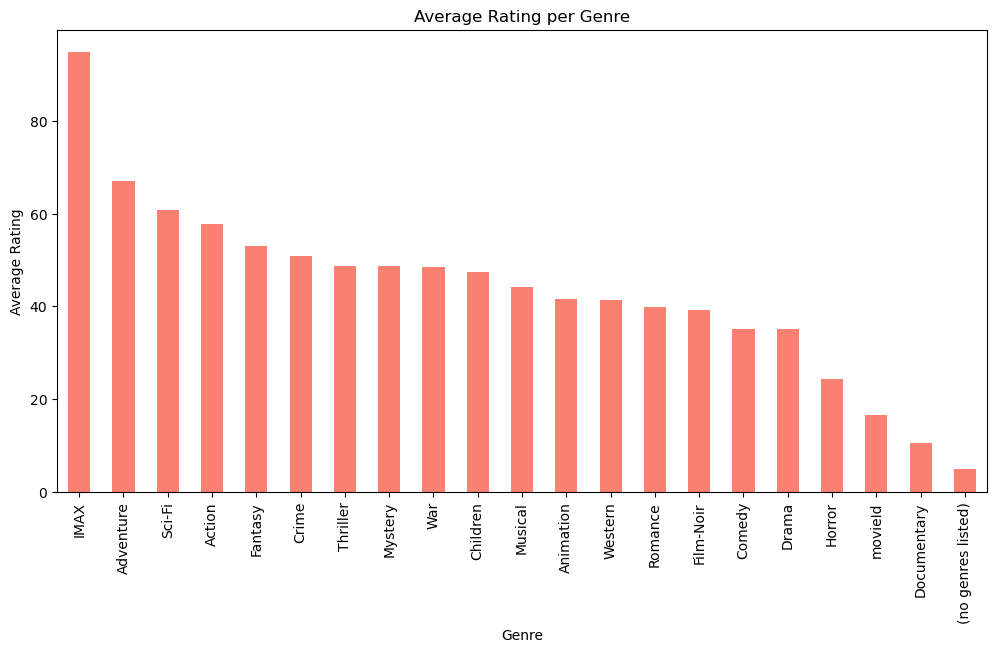

In [13]:
# Step 1: Introduction and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Optional for word cloud of tags
# from wordcloud import WordCloud

# Step 2: Load the Data
ratings = pd.read_csv('data/ratings.csv')
movies = pd.read_csv('data/movies.csv')
tags = pd.read_csv('data/tags.csv')
links = pd.read_csv('data/links.csv')

# Display the first few rows of each file to understand their structure
print("Ratings Data")
display(ratings.head())
print("\nMovies Data")
display(movies.head())
print("\nTags Data")
display(tags.head())
print("\nLinks Data")
display(links.head())

# Step 3: Exploratory Data Analysis
# 3.1: Summary statistics
print("\nRatings Summary Statistics")
display(ratings.describe())

# 3.2: Unique counts
print(f"\nNumber of unique users: {ratings['userId'].nunique()}")
print(f"Number of unique movies: {ratings['movieId'].nunique()}")

# 3.3: Genre distribution visualization
genre_counts = movies['genres'].str.get_dummies(sep='|').sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar')
plt.title("Genre Distribution in MovieLens Dataset")
plt.xlabel("Genres")
plt.ylabel("Count")
plt.show()

# Step 4: Data Cleaning and Preprocessing (continued)
# Filter out users with fewer than 10 reviews

# Count the number of ratings per user
user_review_counts = ratings['userId'].value_counts()

# Identify users with at least 10 reviews
active_users = user_review_counts[user_review_counts >= 10].index

# Filter the ratings dataframe to include only these active users
filtered_ratings = ratings[ratings['userId'].isin(active_users)]

# Display the difference in data size after filtering
print(f"Original number of ratings: {len(ratings)}")
print(f"Number of ratings after filtering: {len(filtered_ratings)}")
print(f"Number of users after filtering: {filtered_ratings['userId'].nunique()}")

# Filter out id froms tag dataset
# Use the same list of active users identified from the ratings data
filtered_tags = tags[tags['userId'].isin(active_users)]

# Display the difference in data size after filtering
print(f"Original number of tags: {len(tags)}")
print(f"Number of tags after filtering: {len(filtered_tags)}")
print(f"Number of users in tags data after filtering: {filtered_tags['userId'].nunique()}")

# Graph distribution of ratings
plt.figure(figsize=(8, 6))
filtered_ratings['rating'].value_counts().sort_index().plot(kind='bar')
plt.title("Distribution of Movie Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

# top 20 most rated movies
top_movies = filtered_ratings['movieId'].value_counts().head(20)
top_movies_titles = movies[movies['movieId'].isin(top_movies.index)]

plt.figure(figsize=(10, 6))
plt.barh(top_movies_titles['title'], top_movies.values, color='skyblue')
plt.title("Top 20 Most Rated Movies")
plt.xlabel("Number of Ratings")
plt.gca().invert_yaxis()
plt.show()

# Expanding genres and calculating average rating per genre
movies_genres_expanded = pd.concat([movies[['movieId']], movies['genres'].str.get_dummies(sep='|')], axis=1)
merged_data = filtered_ratings.merge(movies_genres_expanded, on='movieId')
genre_avg_ratings = merged_data.drop(columns=['userId', 'timestamp', 'rating']).multiply(merged_data['rating'], axis="index").sum() / movies_genres_expanded.sum()

# Plotting the results
plt.figure(figsize=(12, 6))
genre_avg_ratings.sort_values(ascending=False).plot(kind='bar', color='salmon')
plt.title("Average Rating per Genre")
plt.xlabel("Genre")
plt.ylabel("Average Rating")
plt.show()


## Training Data ##
Includes (very) basic reccommendation model using cosine similarity

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import scipy.sparse as sp

# Create a user-item matrix
user_item_matrix = filtered_ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)

# Split the ratings data into train and test sets
train_data, test_data = train_test_split(filtered_ratings, test_size=0.2, random_state=42)

# One-hot encode genres
movies_genres = movies.copy()
movies_genres = pd.concat([movies_genres, movies_genres['genres'].str.get_dummies(sep='|')], axis=1)
movies_genres.drop(columns=['genres'], inplace=True)

from sklearn.feature_extraction.text import TfidfVectorizer

# Combine all tags for each movie
movie_tags = tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()

# Merge tags with movies data
movies_content = movies_genres.merge(movie_tags, on='movieId', how='left')
movies_content['tag'] = movies_content['tag'].fillna('')

# Compute TF-IDF on the tag column
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_content['tag'])

# Combine genre and tag features into a single matrix
genre_matrix = movies_content.drop(columns=['movieId', 'title', 'tag']).values
content_matrix = sp.hstack([sp.csr_matrix(genre_matrix), tfidf_matrix], format='csr')

# Ensure no NaNs by replacing any missing values with zero
content_matrix = np.nan_to_num(content_matrix.toarray())
# Compute the cosine similarity matrix
content_similarity = cosine_similarity(content_matrix)
content_similarity_df = pd.DataFrame(content_similarity, index=movies_content['movieId'], columns=movies_content['movieId'])

def recommend_movies_content(user_id, ratings, num_recommendations=5):
    # Get the movies the user has rated highly
    user_ratings = ratings[(ratings['userId'] == user_id) & (ratings['rating'] >= 4.0)]
    user_movies = user_ratings['movieId'].values
    
    # Collect similarity scores for each movie the user liked
    similar_movies = pd.Series(dtype=float)
    similar_movies_list = [content_similarity_df[movie_id] for movie_id in user_movies]
    similar_movies = pd.concat(similar_movies_list)

    # Aggregate scores, remove movies the user has already rated, and sort
    similar_movies = similar_movies.groupby(similar_movies.index).mean()
    similar_movies = similar_movies.drop(user_movies, errors='ignore')
    recommendations = similar_movies.sort_values(ascending=False).head(num_recommendations)
    
    return movies[movies['movieId'].isin(recommendations.index)][['title', 'movieId']]
# Example usage for a specific user
user_id = 1
recommendations = recommend_movies_content(user_id, filtered_ratings)
print("Recommended movies for user", user_id)
display(recommendations)

Recommended movies for user 1


,title,movieId
3608,"Stunt Man, The (1980)",4956
4005,Flashback (1990),5657
4681,The Great Train Robbery (1978),6990
6570,"Hunting Party, The (2007)",55116
8597,Dragonheart 2: A New Beginning (2000),117646
